# Projet 5: Segmentez les clients d'un site e-commerce (analyse exploratoire)

Objectifs: 
- comprendre les différents **types d'utilisateurs** grâce à leur **comportement** et **données personnelles** => utilisation de méthodes **non supervisées** pour regrouper les clients de profils similaires
- créer une **segmentation des clients** que la société Olist pourra utiliser pour ses **campagnes de communication**. La segmentation proposée doit être exploitable et facile d’utilisation par l'équipe Marketing. Elle doit au minimum pouvoir différencier les **bons et moins bons clients en termes de commandes et de satisfaction**. Nous attendons bien sûr une segmentation sur l’ensemble des clients.
- fournir à l’équipe marketing une **description actionable de la segmentation et de sa logique sous-jacente** pour une utilisation optimale, ainsi qu’une proposition de **contrat de maintenance** basée sur une analyse de la **stabilité des segments au cours du temps**. Une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente doit être faite afin de pouvoir rédiger le devis de contrat de maintenance.

## Table des matières: <a class="anchor" id="0"></a>

1. [Import des librairies et configurations générales](#library)
2. [Chargement et visualisation des données](#data)
3. [Consolidation des données](#conso)


## Import des librairies et configurations générales <a class="anchor" id="library"></a>

In [1]:
# Pour vérifier si la convention PEP8 est respectée
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import unidecode # caractères spéciaux

# Configuration générale des graphiques
parameters = {'axes.labelsize': 13,
              'axes.titlesize': 16,
              'axes.titleweight': 'bold'}
plt.rcParams.update(parameters)

# Modification de l'affichage des lignes et colonnes pour plus de lisibilité
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)
# pd.options.display.float_format = '{:20,.2f}'.format

21:1: E265 block comment should start with '# '


## Chargement et visualisation des données <a class="anchor" id="data"></a>

Olist nous fournit une **base de données anonymisée** comportant des informations sur:

- l’historique de commandes, 
- les produits achetés, 
- les commentaires de satisfaction, 
- et la localisation des clients depuis janvier 2017

Seuls les 3% des clients qui ont réalisé plusieurs commandes nous intéressent.

A noter que le code fourni doit respecter la convention PEP8 pour être exploité par Olist. Quelques exemples de conventions à respecter:
- encodage UTF-8
- indentation de 4 caractères
- 79 caractères par ligne
- imports à déclarer au début du script

Nous allons dans cette partie charger les données de chaque dataset afin de comprendre quelles sont celles qui pourront nous être utiles pour identifier les différents types d'utilisateurs.

Nous vérifierons les également les doublons sur les clefs permettant de faire les jointures.

In [3]:
# Import des datasets
customers = pd.read_csv('data/olist_customers_dataset.csv',
                        sep=',',
                        encoding='utf-8')
customers.name = 'customers'

geo = pd.read_csv('data/olist_geolocation_dataset.csv',
                  sep=',',
                  encoding='utf-8')
geo.name = 'geo'

items = pd.read_csv('data/olist_order_items_dataset.csv',
                    sep=',',
                    encoding='utf-8')
items.name = 'items'

payments = pd.read_csv('data/olist_order_payments_dataset.csv',
                       sep=',',
                       encoding='utf-8')
payments.name = 'payments'

reviews = pd.read_csv('data/olist_order_reviews_dataset.csv',
                      sep=',',
                      encoding='utf-8')
reviews.name = 'reviews'

orders = pd.read_csv('data/olist_orders_dataset.csv',
                     sep=',',
                     encoding='utf-8')
orders.name = 'orders'

products = pd.read_csv('data/olist_products_dataset.csv',
                       sep=',',
                       encoding='utf-8')
products.name = 'products'

sellers = pd.read_csv('data/olist_sellers_dataset.csv',
                      sep=',',
                      encoding='utf-8')
sellers.name = 'sellers'

category = pd.read_csv('data/product_category_name_translation.csv',
                       sep=',',
                       encoding='utf-8')
category.name = 'category'

**Architecture des données**
<img src="data\Data_Scheme.PNG">

### olist_customers_dataset.csv

Ce jeu de données contient des informations sur le **client** et son **emplacement**. Il permet **d'identifier les clients uniques dans l'ensemble de données des commandes** et pour trouver le **lieu de livraison des commandes**.

Le même client aura des identifiants différents pour des commandes différentes. Le but d'avoir un customer_unique_id dans l'ensemble de données est de permettre **d'identifier les clients qui ont fait des réachats au magasin**.

In [4]:
# Visualisation des 5 premières lignes du dataset
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
def shape_total_nan(dataframe):
    '''Fonction qui retourne le nombre de lignes,
    de variables, le nombre total de valeurs manquantes et
    le pourcentage associé'''
    missing = dataframe.isna().sum().sum()
    missing_percent = round(missing
                            / (dataframe.shape[0] * dataframe.shape[1])
                            * 100,
                            2)

    print(f"Nombre de lignes: {dataframe.shape[0]}")
    print(f"Nombre de colonnes: {dataframe.shape[1]}")
    print(f"Nombre total de NaN du dataset: {missing}")
    print(f"% total de NaN du dataset: {missing_percent}%")

In [6]:
shape_total_nan(customers)

Nombre de lignes: 99441
Nombre de colonnes: 5
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [7]:
def describe_variables(data):
    ''' fonction qui prend un dataframe en entrée, et retourne un
    récapitulatif qui contient le nom des variables, leur type, un
    exemple de modalité, le nombre total de lignes, le nombre et
    pourcentage de valeurs distinctes, le nombre et pourcentage de
    valeurs non manquantes et de valeurs manquantes (NaN) et les
    principales statistiques pour les variables numériques (moyenne,
    médiane, distribution, variance, écart type, minimum, quartiles et
    maximum)'''

    # Choix du nom des variables à afficher
    df = pd.DataFrame(columns=[
        'Variable name', 'Variable type', 'Example', 'Raws', 'Distinct',
        '% distinct', 'Not NaN', '% Not NaN', 'NaN', '% NaN', 'Mean',
        'Median', 'Skew', 'Kurtosis', 'Variance', 'Std', 'Min', '25%',
        '75%', 'Max'
    ])

    # Pour chaque colonne du dataframe
    for col in data.columns:

        # Définition des variables
        # type de la variable (object, float, int...)
        var_type = data[col].dtypes
        # premier élément notNA
        example = data[data[col].notna()][col].iloc[0]
        # nombre total de lignes
        nb_raw = len(data[col])
        # nombre de valeurs non manquantes
        count = len(data[col]) - data[col].isna().sum()
        # % de valeurs non manquantes
        percent_count = round(data[col].notnull().mean(), 4)*100
        # nombre de modalités que peut prendre la variable
        distinct = data[col].nunique()
        # % de valeurs distinctes
        percent_distinct = round(data[col].nunique()/len(data[col]), 4)
        percent_distinct = percent_distinct * 100
        # nombre de valeurs manquantes
        missing = data[col].isna().sum()
        # % de valeurs manquantes
        percent_missing = round(data[col].isna().mean(), 4)*100

        # Pour les var de type 'int' ou 'float': on remplit toutes les col
        if var_type == 'int' or var_type == 'float':
            df = df.append(pd.DataFrame([[col, var_type, example, nb_raw,
                                          distinct, percent_distinct, count,
                                          percent_count,
                                          missing,
                                          percent_missing,
                                          round(data[col].mean(), 2),
                                          round(data[col].median(), 2),
                                          round(data[col].skew(), 2),
                                          round(data[col].kurtosis(), 2),
                                          round(data[col].var(), 2),
                                          round(data[col].std(), 2),
                                          round(data[col].min(), 2),
                                          round(data[col].quantile(0.25), 2),
                                          round(data[col].quantile(0.75), 2),
                                          data[col].max()]],
                                        columns=['Variable name',
                                                 'Variable type',
                                                 'Example', 'Raws',
                                                 'Distinct',
                                                 '% distinct',
                                                 'Not NaN',
                                                 '% Not NaN',
                                                 'NaN', '% NaN',
                                                 'Mean', 'Median',
                                                 'Skew', 'Kurtosis',
                                                 'Variance', 'Std',
                                                 'Min', '25%',
                                                 '75%', 'Max']))

            # Pour les variables d'un autre type: on ne remplit que
            # les variables de compte

        else:
            df = df.append(pd.DataFrame([[col, var_type, example,
                                          nb_raw, distinct,
                                          percent_distinct, count,
                                          percent_count, missing,
                                          percent_missing,
                                          '', '', '', '', '', '',
                                          '', '', '', '']],
                                        columns=['Variable name',
                                                 'Variable type',
                                                 'Example',
                                                 'Raws', 'Distinct',
                                                 '% distinct', 'Not NaN',
                                                 '% Not NaN', 'NaN',
                                                 '% NaN', 'Mean',
                                                 'Median', 'Skew',
                                                 'Kurtosis', 'Variance',
                                                 'Std', 'Min', '25%',
                                                 '75%', 'Max']))

    return df.reset_index(drop=True)

In [8]:
describe_variables(customers)

C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFram

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,customer_id,object,06b8999e2fba1a1fbc88172c00ba8bc7,99441,99441,100.0,99441,100.0,0,0.0,,,,,,,,,,
1,customer_unique_id,object,861eff4711a542e4b93843c6dd7febb0,99441,96096,96.64,99441,100.0,0,0.0,,,,,,,,,,
2,customer_zip_code_prefix,int64,14409,99441,14994,15.08,99441,100.0,0,0.0,,,,,,,,,,
3,customer_city,object,franca,99441,4119,4.14,99441,100.0,0,0.0,,,,,,,,,,
4,customer_state,object,SP,99441,27,0.03,99441,100.0,0,0.0,,,,,,,,,,


In [9]:
def univ_plots_hist(dataframe, liste_col_quanti, nb_lignes, nb_col, nb_bins):

    for i, c in enumerate(liste_col_quanti, 1):
        ax = fig.add_subplot(nb_lignes, nb_col, i)
        ax.hist(dataframe[c], bins=nb_bins, color='#0c29d0')
        ax.set_title(c, fontsize=10)
        ax.title.set_fontweight('bold')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout(w_pad=2, h_pad=2)
    plt.show

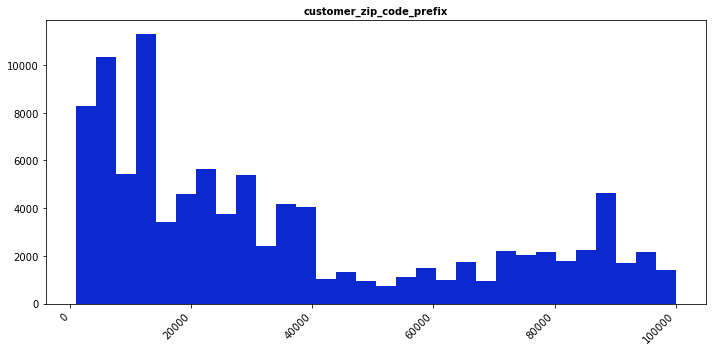

In [10]:
col_quanti = customers.select_dtypes(exclude='object').columns.tolist()
fig = plt.figure(figsize=(10, 5))
univ_plots_hist(customers, col_quanti, 1, 1, 30)

In [11]:
def univariate_plots_quali(dataframe, liste_col_quali, nb_lignes, nb_col):
    for i, c in enumerate(liste_col_quali, 1):
        ax = fig.add_subplot(nb_lignes, nb_col, i)
        modalites = dataframe[c].value_counts()
        n_modalites = modalites.shape[0]

        if n_modalites > 15:
            modalites[0:15].plot.bar(color='#0c29d0', edgecolor='black', ax=ax)

        else:
            modalites.plot.bar(color='#0c29d0', edgecolor='black')

        ax.set_title(f'{c} ({n_modalites} modalités)',
                     fontweight='bold', fontsize=10)
        labels = [item.get_text() for item in ax.get_xticklabels()]
        short_labels = [lab[0:7] + '.' if len(lab) > 7
                        else lab for lab in labels]
        ax.axes.set_xticklabels(short_labels)
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout(w_pad=2, h_pad=2)
    plt.show

['customer_city', 'customer_state']


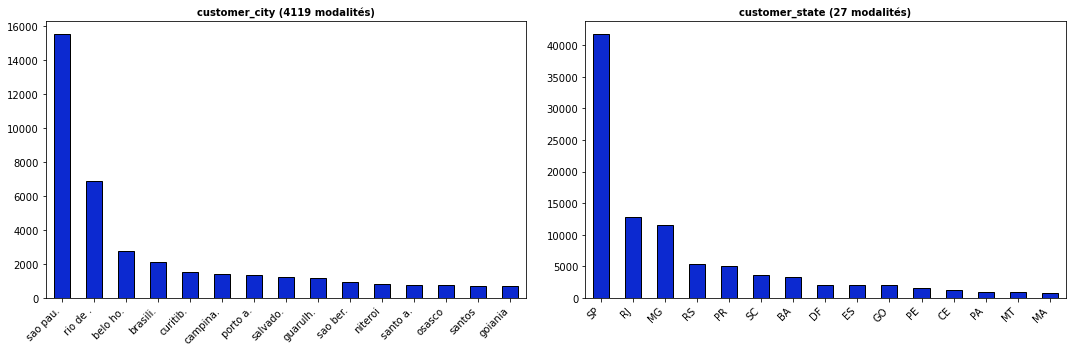

In [12]:
col_quali = customers.select_dtypes(include='object').columns.tolist()
col_quali.remove('customer_id')
col_quali.remove('customer_unique_id')
print(col_quali)

fig = plt.figure(figsize=(15, 5))
univariate_plots_quali(customers, col_quali, 1, 2)

In [13]:
# Nombre de doublons totaux
print(f"Lignes en doublons: {customers.duplicated().sum()}")

Lignes en doublons: 0


In [14]:
# Nombre de doublons sur la clef de jointure customer_id
print(f"Doublons: {customers.duplicated('customer_id').sum()}")

Doublons: 0


In [15]:
# customer_unique_id en doublon
customers_duplicated = customers["customer_unique_id"].value_counts()
customers_duplicated[customers_duplicated > 1]

8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
370cd3b09ea745fe047fd11db7430441     2
d7c6bdf20c4ec9c9cda815dde58e778a     2
a366793a4999f8cc135855c4dd347421     2
156283b6ca35ef976a0265903145fd5e     2
d83257348027bd8c59a228cc034de5e3     2
Name: customer_unique_id, Length: 2997, dtype: int64

Observations:

- aucune valeur manquante
- la variable customer_id ne comporte que des éléments uniques
- certains customer_unique_id apparaissent sur plusieurs lignes du dataset
- ce dataset est relié au dataset geolocation par la clef zip_code_prefix et au dataset orders par la clef customer_id%

### olist_geolocation_dataset.csv

Ce jeu de données contient des informations sur les **codes postaux** brésiliens et leurs coordonnées **lat/lng**. Il permet de calculer la distance entre le vendeur et le client.

In [16]:
# Visualisation des 5 premières lignes du dataset
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [17]:
# Shape du dataset
shape_total_nan(geo)

Nombre de lignes: 1000163
Nombre de colonnes: 5
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [18]:
# Description des variables
describe_variables(geo)

C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example, nb_raw,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example, nb_raw,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.ap

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,geolocation_zip_code_prefix,int64,1037,1000163,19015,1.9,1000163,100.0,0,0.0,,,,,,,,,,
1,geolocation_lat,float64,-23.545621,1000163,717360,71.72,1000163,100.0,0,0.0,-21.18,-22.92,1.57,2.85,32.67,5.72,-36.61,-23.6,-19.98,45.065933
2,geolocation_lng,float64,-46.639292,1000163,717613,71.75,1000163,100.0,0,0.0,-46.39,-46.64,-0.1,4.73,18.23,4.27,-101.47,-48.57,-43.77,121.105394
3,geolocation_city,object,sao paulo,1000163,8011,0.8,1000163,100.0,0,0.0,,,,,,,,,,
4,geolocation_state,object,SP,1000163,27,0.0,1000163,100.0,0,0.0,,,,,,,,,,


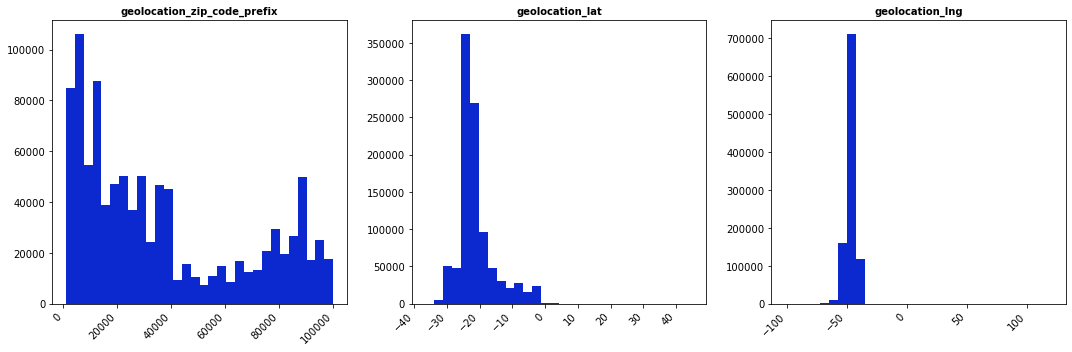

In [19]:
col_quanti = geo.select_dtypes(exclude='object').columns.tolist()
fig = plt.figure(figsize=(15, 5))
univ_plots_hist(geo, col_quanti, 1, 3, 30)

['geolocation_city', 'geolocation_state']


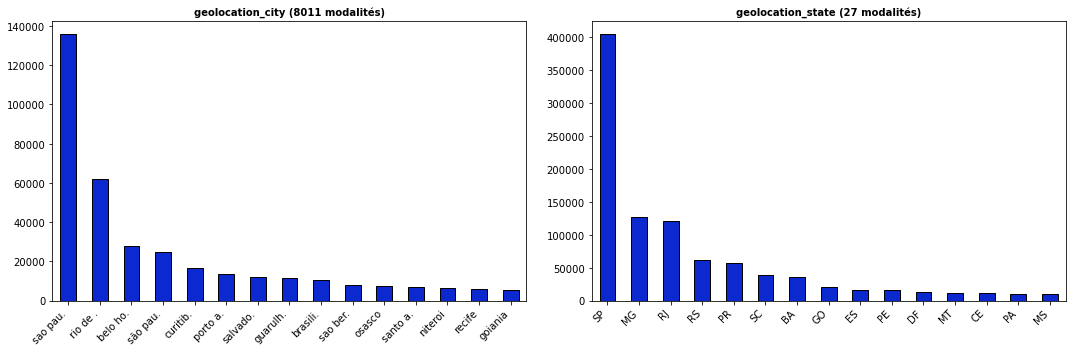

In [20]:
col_quali = geo.select_dtypes(include='object').columns.tolist()
print(col_quali)

fig = plt.figure(figsize=(15, 5))
univariate_plots_quali(geo, col_quali, 1, 2)

In [21]:
# Doublons totaux
print(f"Lignes en doublons: {geo.duplicated().sum()}")

Lignes en doublons: 261831


In [23]:
# Suppression des doublons intégraux
geo = geo.drop_duplicates()
geo.shape

(738332, 5)

In [35]:
# Nombre de doublons sur la clef de jointure zip_code_prefix
print(f"Doublons: {geo.duplicated('geolocation_zip_code_prefix').sum()}")

# Récupération des zip_code_prefix qui apparaissent plusieurs fois
zip_code_dup = geo[geo.duplicated('geolocation_zip_code_prefix')][
    'geolocation_zip_code_prefix'].unique()

# Filtrage du dataset sur les zip_code_prefix en doublon
geo_dup = geo[geo['geolocation_zip_code_prefix'].isin(
    zip_code_dup)].sort_values(
    by='geolocation_zip_code_prefix')
geo_dup

Doublons: 719317


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
851,1001,-23.549825,-46.633970,sao paulo,SP
326,1001,-23.551427,-46.634074,sao paulo,SP
299,1001,-23.549698,-46.633909,sao paulo,SP
235,1001,-23.550642,-46.634410,sao paulo,SP
519,1001,-23.551337,-46.634027,sao paulo,SP
...,...,...,...,...,...
999808,99980,-28.387842,-51.846890,david canabarro,RS
999775,99980,-28.386689,-51.847091,david canabarro,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS
999864,99990,-28.329472,-51.769109,muliterno,RS


Un même zip_code prefix peut avoir différentes latitudes et longitudes. Afin d'avoir des zip_codes uniques, nous allons calculer la moyenne des latitudes et longitudes par code postal puis récupérer la ville et l'état:

In [93]:
# Moyenne des lat et lon par code postal
zip_mean = geo.groupby('geolocation_zip_code_prefix')[
    ['geolocation_lat', 'geolocation_lng']].mean()

# On conserve une ville par code postal
zip_city = geo[['geolocation_zip_code_prefix',
                'geolocation_city',
                'geolocation_state']].groupby(
    ['geolocation_zip_code_prefix',
     'geolocation_city',
     'geolocation_state']).count().reset_index()

zip_city = zip_city.drop_duplicates('geolocation_zip_code_prefix',
                                    keep='first')

# Merge
geo = pd.merge(left=zip_mean, right=zip_city,
               how='left', on='geolocation_zip_code_prefix')

<div class="alert alert-block alert-info">
    <p> Comment retourner le nom du dataframe et non pas le dataframe? </p>
</div>

In [90]:
#def compar_modalities(df1, col1, df2, col2):
#
#    df1.name = str(df1)
#    df2.name = str(df2)
#
#   df1_mod = df1[col1].unique().tolist()
#   df2_mod = df2[col2].unique()
#
#    difference_1 = set(df1_mod).difference(set(df2_mod))
#    difference_2 = set(df2_mod).difference(set(df1_mod))
#
#    list_difference = list(difference_1.union(difference_2))
#
#    print(f'Modalités présentes uniquement dans la colonne\
#    {col1} de {df1.name}: \n {difference_1}')
#    print('------------------------------------------------------------------')
#    print(f'Colonnes présentes uniquement dans la colonne\
#    {col2} de {df2.name}: \n {difference_2}')

Observations:

- aucune valeur manquante
- un grand nombre de lignes en doublons qui ont été supprimées
- d'après l'architecture des données, le zip_code_prefix est la clef qui fait le lien avec les datasets customers et sellers
- ce dataset est dorénavant composé d'une observation par code postal

### olist_order_items_dataset.csv

Ce dataset inclut les informations sur éléments achetés de chaque commande.

In [106]:
# Visualisation des premières lignes du dataset
items.sort_values(by='product_id').head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
106927,f30149f4a8882a08895b6a242aa0d612,1,00066f42aeeb9f3007548bb9d3f33c38,5670f4db5b62c43d542e1b2d56b0cf7c,2018-05-24 18:58:59,101.65,18.59
108215,f5eda0ded77c1293b04c953138c8331d,1,00088930e925c41fd95ebfe695fd2655,7142540dd4c91e2237acb7e911c4eba2,2017-12-18 19:32:19,129.90,13.93
5273,0bf736fd0fd5169d60de3699fcbcf986,1,0009406fd7479715e4bef61dd91f2462,4a3ca9315b744ce9f8e9374361493884,2017-12-29 16:12:36,229.00,13.10
48878,6f0dfb5b5398b271cc6bbd9ee263530e,1,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-07 22:15:19,58.90,19.60
25833,3aba44d8e554ab4bb8c09f6f78032ca8,1,000b8f95fcb9e0096488278317764d19,40ec8ab6cdafbcc4f544da38c67da39a,2018-08-16 13:35:21,58.90,19.60
73160,a6c1ae4d48280b5b3c43231ac6afd701,1,000d9be29b5207b54e86aa1b1ac54872,8ae520247981aa06bc94abddf5f46d34,2018-04-09 10:09:40,199.00,19.27
82591,bb9552306cf6879fde49f4ba3bd94299,2,0011c512eb256aa0dbbb544d8dffcf6e,b4ffb71f0cb1b1c3d63fad021ecf93e1,2017-12-22 20:38:29,52.00,15.80
88768,c9a34c30282dc36d017bc912f8d8dc91,1,00126f27c813603687e6ce486d909d01,cd68562d3f44870c08922d380acae552,2017-09-21 20:55:19,249.00,13.24
93674,d44be4540d1a35533a9f5c89377b77f1,1,00126f27c813603687e6ce486d909d01,cd68562d3f44870c08922d380acae552,2017-09-21 20:50:13,249.00,16.49
86374,c432657bb18ddf7f48b7227db09048d4,2,001795ec6f1b187d37335e1c4704762e,8b321bb669392f5163d04c59e235e066,2017-12-18 00:39:25,38.90,16.11


In [95]:
# Shape du dataset
shape_total_nan(items)

Nombre de lignes: 112650
Nombre de colonnes: 7
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [96]:
# Description des variables
describe_variables(items)

C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFram

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,order_id,object,00010242fe8c5a6d1ba2dd792cb16214,112650,98666,87.59,112650,100.0,0,0.0,,,,,,,,,,
1,order_item_id,int64,1,112650,21,0.02,112650,100.0,0,0.0,,,,,,,,,,
2,product_id,object,4244733e06e7ecb4970a6e2683c13e61,112650,32951,29.25,112650,100.0,0,0.0,,,,,,,,,,
3,seller_id,object,48436dade18ac8b2bce089ec2a041202,112650,3095,2.75,112650,100.0,0,0.0,,,,,,,,,,
4,shipping_limit_date,object,2017-09-19 09:45:35,112650,93318,82.84,112650,100.0,0,0.0,,,,,,,,,,
5,price,float64,58.9,112650,5968,5.3,112650,100.0,0,0.0,120.65,74.99,7.92,120.83,33721.42,183.63,0.85,39.9,134.9,6735.0
6,freight_value,float64,13.29,112650,6999,6.21,112650,100.0,0,0.0,19.99,16.26,5.64,59.79,249.84,15.81,0.0,13.08,21.15,409.68


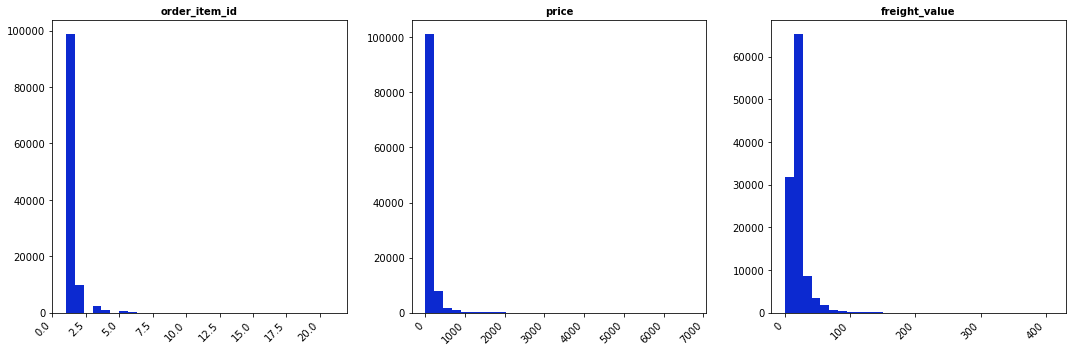

In [97]:
col_quanti = items.select_dtypes(exclude='object').columns.tolist()
fig = plt.figure(figsize=(15, 5))
univ_plots_hist(items, col_quanti, 1, 3, 30)

['order_id', 'product_id', 'seller_id', 'shipping_limit_date']


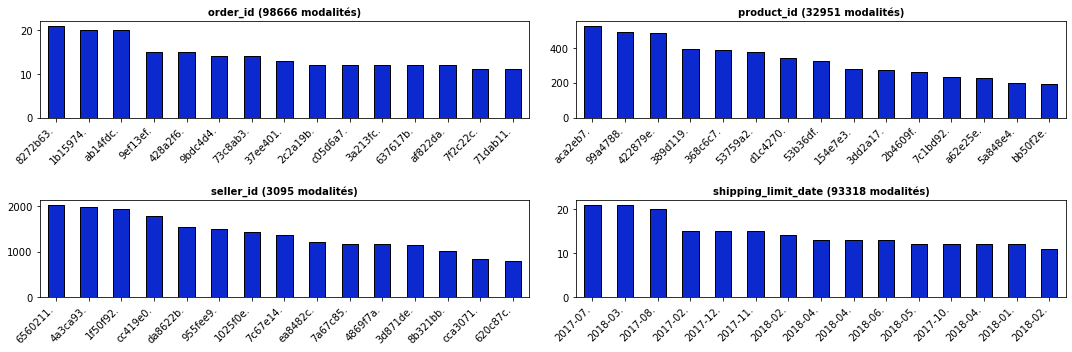

In [98]:
col_quali = items.select_dtypes(include='object').columns.tolist()
print(col_quali)

fig = plt.figure(figsize=(15, 5))
univariate_plots_quali(items, col_quali, 2, 2)

In [99]:
# Doublons totaux
print(f"Lignes en doublons: {items.duplicated().sum()}")

Lignes en doublons: 0


In [107]:
# Nombre de doublons sur la clef de jointure order_id
print(f"Doublons: {items.duplicated(['order_id']).sum()}")

# Récupération des order_id qui apparaissent plusieurs fois
order_id_dup = items[items.duplicated('order_id')][
    'order_id'].unique()

# Filtrage du dataset sur les order_id en doublon
items_dup = items[items['order_id'].isin(
    order_id_dup)].sort_values(
    by='order_id')
items_dup

Doublons: 13984


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
...,...,...,...,...,...,...,...
112634,fff8287bbae429a99bb7e8c21d151c41,1,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,2018-03-27 12:29:22,180.00,48.14
112641,fffb9224b6fc7c43ebb0904318b10b5f,2,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112642,fffb9224b6fc7c43ebb0904318b10b5f,3,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19
112640,fffb9224b6fc7c43ebb0904318b10b5f,1,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.00,34.19


Un même order_id peut apparaitre plusieurs fois, c'est à dire à chaque fois qu'un article est rajouté dans la commande. Il ne s'agit pas de doublons.

Observations:

- aucune valeur manquante
- d'après l'architecture des données, le seller_id est la clef qui fait le lien avec le dataset sellers, order_id avec le dataset orders et product_id avec le dataset products
- il existe plusieurs lignes pour un même order_id, il s'agit des différents produits rajoutés dans la commande

### olist_order_payments_dataset.csv

Ce dataset contient les informations sur les options de paiement.

In [108]:
# Visualisation des 5 premières lignes du dataset
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [109]:
# Shape du dataset
shape_total_nan(payments)

Nombre de lignes: 103886
Nombre de colonnes: 5
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [110]:
# Description des variables
describe_variables(payments)

C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFram

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,order_id,object,b81ef226f3fe1789b1e8b2acac839d17,103886,99440,95.72,103886,100.0,0,0.0,,,,,,,,,,
1,payment_sequential,int64,1,103886,29,0.03,103886,100.0,0,0.0,,,,,,,,,,
2,payment_type,object,credit_card,103886,5,0.0,103886,100.0,0,0.0,,,,,,,,,,
3,payment_installments,int64,8,103886,24,0.02,103886,100.0,0,0.0,,,,,,,,,,
4,payment_value,float64,99.33,103886,29077,27.99,103886,100.0,0,0.0,154.1,100.0,9.25,241.83,47303.67,217.49,0.0,56.79,171.84,13664.08


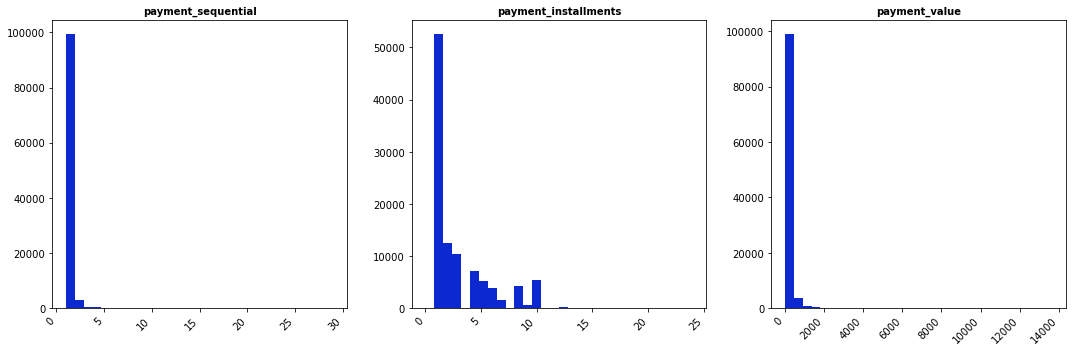

In [111]:
col_quanti = payments.select_dtypes(exclude='object').columns.tolist()
fig = plt.figure(figsize=(15, 5))
univ_plots_hist(payments, col_quanti, 1, 3, 30)

['order_id', 'payment_type']


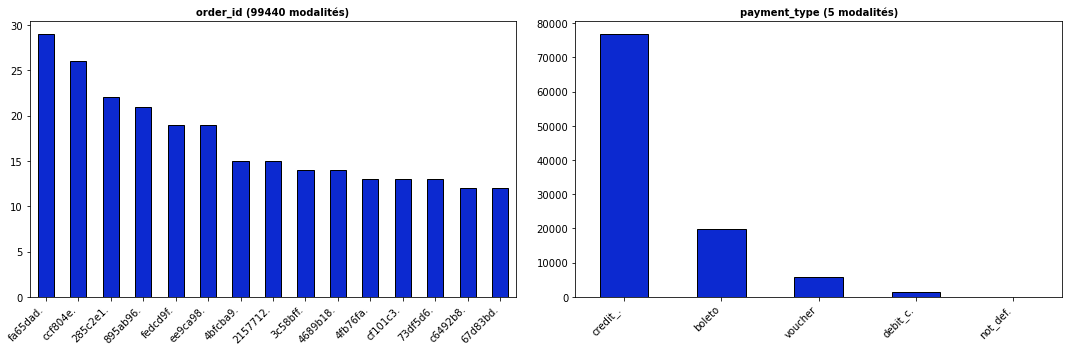

In [112]:
col_quali = payments.select_dtypes(include='object').columns.tolist()
print(col_quali)

fig = plt.figure(figsize=(15, 5))
univariate_plots_quali(payments, col_quali, 1, 2)

In [113]:
# Doublons totaux
print(f"Lignes en doublons: {payments.duplicated().sum()}")

Lignes en doublons: 0


In [114]:
# Nombre de doublons sur la clef de jointure order_id
print(f"Doublons: {payments.duplicated(['order_id']).sum()}")

# Récupération des order_id qui apparaissent plusieurs fois
order_id_dup = payments[payments.duplicated('order_id')][
    'order_id'].unique()

# Filtrage du dataset sur les order_id en doublon
payments_dup = payments[payments['order_id'].isin(
    order_id_dup)].sort_values(
    by='order_id')
payments_dup

Doublons: 4446


,order_id,payment_sequential,payment_type,payment_installments,payment_value
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
20036,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
98894,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
30155,0071ee2429bc1efdc43aa3e073a5290e,2,voucher,1,92.44
...,...,...,...,...,...
21648,ffa1dd97810de91a03abd7bd76d2fed1,2,voucher,1,418.73
32912,ffa39020fe7c8a3e907320e1bec4b985,1,credit_card,1,7.13
3009,ffa39020fe7c8a3e907320e1bec4b985,2,voucher,1,64.01
75188,ffc730a0615d28ec19f9cad02cb41442,1,credit_card,1,14.76


Une même commande peut apparaitre sur plusieurs lignes. C'est le cas lorsque le client a payé avec 2 méthodes différentes. La variable payment_installments correspond au nombre de versements effectués par type de paiment. Il ne s'agit donc pas de doublons.

Observations:

- aucune valeur manquante
- d'après l'architecture des données, l'order_id est la clef qui fait le lien avec le dataset orders
- order_id apparait sur plusieurs lignes lorsque le client a utilisé différents moyens de paiment

### olist_order_reviews_dataset.csv

Ce dataset contient les informations sur les commentaires des clients.

Après qu'un client ait acheté un produit sur Olist Store, le vendeur est informé qu'il doit exécuter la commande. Une fois que le client a reçu le produit, ou que la date de livraison estimée est arrivée, le client reçoit une enquête de satisfaction par e-mail où il peut donner une note sur l'expérience d'achat et écrire quelques commentaires.

In [128]:
# Visualisation des 5 premières lignes du dataset
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa,2018-03-01 00:00:00,2018-03-02 10:26:53


In [129]:
# Shape du dataset
shape_total_nan(reviews)

Nombre de lignes: 99224
Nombre de colonnes: 7
Nombre total de NaN du dataset: 145903
% total de NaN du dataset: 21.01%


In [140]:
# Description des variables
describe_variables(reviews)

C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFram

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,review_id,object,13548d0f62b03a0d3cb6efc00877fa13,98673,98095,99.41,98673,100.0,0,0.0,,,,,,,,,,
1,order_id,object,30a2f24dd6770c91faa6b3481319204b,98673,98673,100.0,98673,100.0,0,0.0,,,,,,,,,,
2,review_score,int64,5,98673,5,0.01,98673,100.0,0,0.0,,,,,,,,,,
3,review_comment_title,object,Muito bonita,98673,4525,4.59,11553,11.71,87120,88.29,,,,,,,,,,
4,review_comment_message,object,"Amei a mesinha, que pena que me confundir na cor, comprei achando que seria branca, mas é nude. mas tudo bem, muito bonita, vale a pena",98673,36091,36.58,40836,41.39,57837,58.61,,,,,,,,,,
5,review_creation_date,object,2018-08-14 00:00:00,98673,636,0.64,98673,100.0,0,0.0,,,,,,,,,,
6,review_answer_timestamp,object,2018-10-29 12:27:35,98673,97933,99.25,98673,100.0,0,0.0,,,,,,,,,,


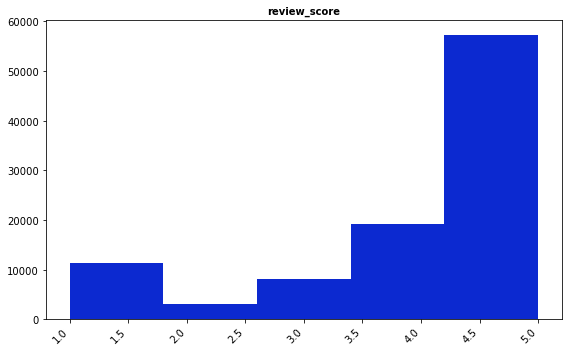

In [131]:
col_quanti = reviews.select_dtypes(exclude='object').columns.tolist()
fig = plt.figure(figsize=(8, 5))
univ_plots_hist(reviews, col_quanti, 1, 1, 5)

['review_id', 'order_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']


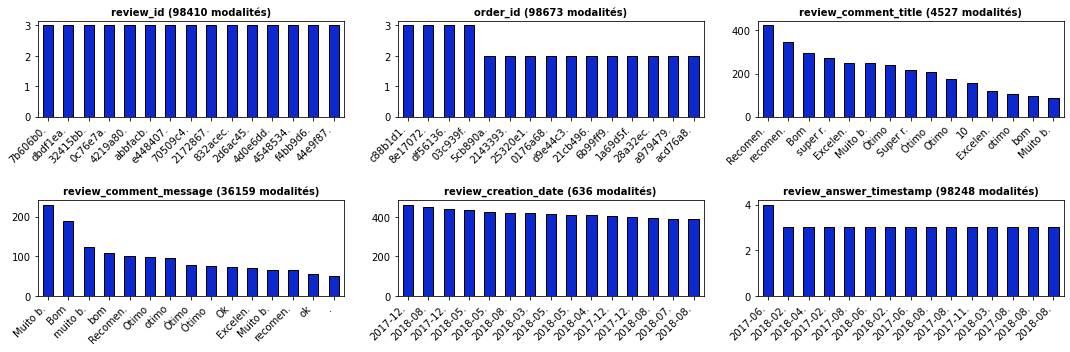

In [132]:
col_quali = reviews.select_dtypes(include='object').columns.tolist()
print(col_quali)

fig = plt.figure(figsize=(15, 5))
univariate_plots_quali(reviews, col_quali, 2, 3)

In [133]:
# Doublons totaux
print(f"Lignes en doublons: {reviews.duplicated().sum()}")

Lignes en doublons: 0


In [134]:
# Doublons sur la clef order_id
print(f"Lignes en doublons: {reviews.duplicated('order_id').sum()}")

# Récupération des order_id qui apparaissent plusieurs fois
order_id_dup = reviews[reviews.duplicated('order_id')]['order_id'].unique()

# Filtrage du dataset sur les order_id en doublon
reviews_dup = reviews[reviews['order_id'].isin(order_id_dup)].sort_values(
    by='order_id')
reviews_dup

Lignes en doublons: 551


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29 00:00:00,2017-08-30 01:59:12
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,"Estou acostumada a comprar produtos pelo baratheon. Super confiável, transparência, qualidade e agilidade. Super recomendo.",2017-08-25 00:00:00,2017-08-29 21:45:57
22779,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22 00:00:00,2018-02-23 12:12:30
68633,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04 00:00:00,2018-03-05 17:02:00
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:06
...,...,...,...,...,...,...,...
27465,5e78482ee783451be6026e5cf0c72de1,ff763b73e473d03c321bcd5a053316e8,3,NaN,Não sei que haverá acontecido os demais chegaram,2017-11-18 00:00:00,2017-11-18 09:02:48
41355,39de8ad3a1a494fc68cc2d5382f052f4,ff850ba359507b996e8b2fbb26df8d03,5,NaN,Envio rapido... Produto 100%,2017-08-16 00:00:00,2017-08-17 11:56:55
18783,80f25f32c00540d49d57796fb6658535,ff850ba359507b996e8b2fbb26df8d03,5,NaN,"Envio rapido, produto conforme descrito no anuncio.",2017-08-22 00:00:00,2017-08-25 11:40:22
92230,870d856a4873d3a67252b0c51d79b950,ffaabba06c9d293a3c614e0515ddbabc,3,NaN,NaN,2017-12-20 00:00:00,2017-12-20 18:50:16


Une même clef de jointure order_id existe plusieurs fois dans le dataset. Nous allons essayer de comprendre et de trouver une stratégie pour traiter ces doublons.

Stratégie de traitement des order_id_dupliqués:
- Completion des variables review_comment_message et review_comment_title NaN lorsque l'information existe sur une autre ligne
- On garde la date du commentaire la plus récente (review_answer_timestamp) 

In [135]:
def mapping(dataframe, var_to_map, var_mapping):
    table_mapping = dataframe.groupby(
        [var_mapping, var_to_map])['review_id'].count().reset_index()
    table_mapping = table_mapping.sort_values(var_to_map,
                                              ascending=True)  # sur col txt
    table_mapping = table_mapping.drop_duplicates(subset=var_mapping,
                                                  # first car nan after
                                                  keep='first')

    # Merge du dataframe avec la table de mapping
    df = pd.merge(left=dataframe, right=table_mapping[[var_mapping,
                                                       var_to_map]],
                  how="left", on=var_mapping)

    # Lorsque la var_to_map est NaN, je complète avec la valeur du mapping
    df[f'{var_to_map}_x'] = np.where(df[f'{var_to_map}_x'].isnull(),
                                     df[f'{var_to_map}_y'],
                                     df[f'{var_to_map}_x'])

    # On supprime la variable issue de la jointure et on enlève le suffixe _x
    df.rename(columns={f'{var_to_map}_x': var_to_map}, inplace=True)
    df.drop(f'{var_to_map}_y', axis='columns', inplace=True)

    return df

In [137]:
# Completion des variables ayant le même order_id
reviews = mapping(reviews, 'review_comment_message', 'order_id')
reviews = mapping(reviews, 'review_comment_title', 'order_id')

In [139]:
# Suppression des order_id dupliqués en conservant celui
# qui a le commentaire le plus récent
reviews = reviews.sort_values(by='review_answer_timestamp',
                              ascending=False).drop_duplicates('order_id',
                                                               keep='first')

# Doublons sur la clef order_id
print(f"Lignes en doublons: {reviews.duplicated('order_id').sum()}")

Lignes en doublons: 0


Observations:

- valeurs manquantes sur les variables sur les titres et commentaires des questionnaires de satisfaction envoyés aux clients
- d'après l'architecture des données, l'order_id est la clef qui fait le lien avec le dataset orders
- doublons sur l'order_id retraités en completant les valeurs manquantes puis conservant la date de commentaire la plus récente

### olist_orders_dataset.csv

Dataset principal sur les commandes passées par les différents clients.

In [141]:
# Visualisation des 5 premières lignes du dataset
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [142]:
# Shape du dataset
shape_total_nan(orders)

Nombre de lignes: 99441
Nombre de colonnes: 8
Nombre total de NaN du dataset: 4908
% total de NaN du dataset: 0.62%


In [143]:
# Description des variables
describe_variables(orders)

C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFram

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,order_id,object,e481f51cbdc54678b7cc49136f2d6af7,99441,99441,100.0,99441,100.0,0,0.0,,,,,,,,,,
1,customer_id,object,9ef432eb6251297304e76186b10a928d,99441,99441,100.0,99441,100.0,0,0.0,,,,,,,,,,
2,order_status,object,delivered,99441,8,0.01,99441,100.0,0,0.0,,,,,,,,,,
3,order_purchase_timestamp,object,2017-10-02 10:56:33,99441,98875,99.43,99441,100.0,0,0.0,,,,,,,,,,
4,order_approved_at,object,2017-10-02 11:07:15,99441,90733,91.24,99281,99.84,160,0.16,,,,,,,,,,
5,order_delivered_carrier_date,object,2017-10-04 19:55:00,99441,81018,81.47,97658,98.21,1783,1.79,,,,,,,,,,
6,order_delivered_customer_date,object,2017-10-10 21:25:13,99441,95664,96.2,96476,97.02,2965,2.98,,,,,,,,,,
7,order_estimated_delivery_date,object,2017-10-18 00:00:00,99441,459,0.46,99441,100.0,0,0.0,,,,,,,,,,


['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']


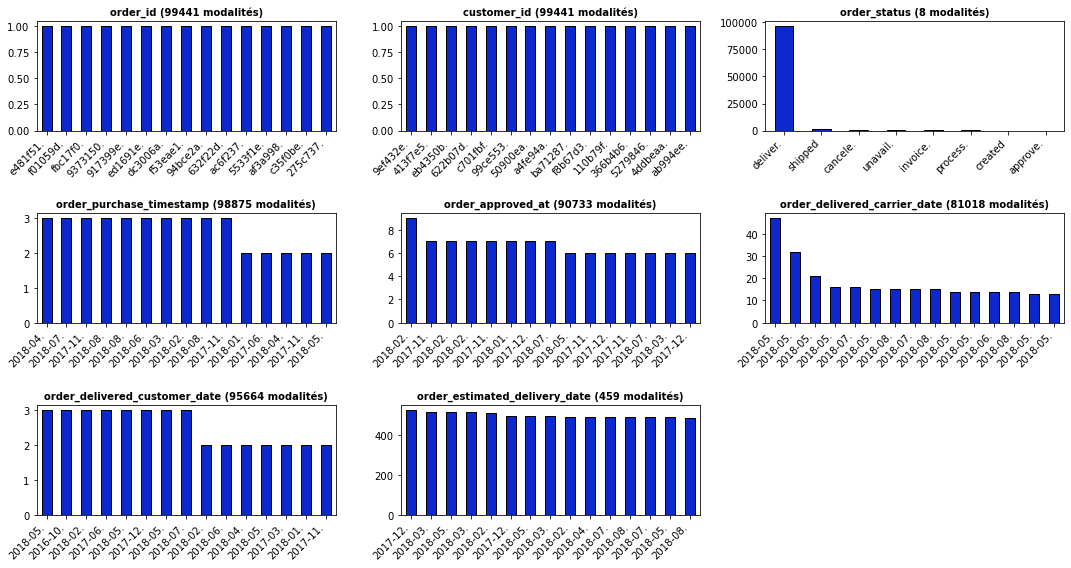

In [144]:
col_quali = orders.select_dtypes(include='object').columns.tolist()
print(col_quali)

fig = plt.figure(figsize=(15, 8))
univariate_plots_quali(orders, col_quali, 3, 3)

In [145]:
# Doublons totaux
print(f"Lignes en doublons: {orders.duplicated().sum()}")

Lignes en doublons: 0


Observations:

- quelques valeurs manquantes sur les variables order_approved_at, order_delivered_carrier_date et order_delivered_customer_date ce qui semble cohérent. En effet, une commande peut ne pas avoir été validée ou livrée.
- d'après l'architecture des données, l'order_id est la clef qui fait le lien avec les datasets order_payments, order_reviews et order_items => pas de doublons
- customer_id est la clef qui fait le lien avec order_customer => pas de doublons

### olist_products_dataset.csv

Dataset rassemblant tous les produits vendus par Olist.

In [146]:
# Visualisation des 5 premières lignes du dataset
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [147]:
# Shape du dataset
shape_total_nan(products)

Nombre de lignes: 32951
Nombre de colonnes: 9
Nombre total de NaN du dataset: 2448
% total de NaN du dataset: 0.83%


In [148]:
# Description des variables
describe_variables(products)

C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example, nb_raw,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,product_id,object,1e9e8ef04dbcff4541ed26657ea517e5,32951,32951,100.0,32951,100.0,0,0.0,,,,,,,,,,
1,product_category_name,object,perfumaria,32951,73,0.22,32341,98.15,610,1.85,,,,,,,,,,
2,product_name_lenght,float64,40.0,32951,66,0.2,32341,98.15,610,1.85,48.48,51.0,-0.9,0.19,104.98,10.25,5.0,42.0,57.0,76.0
3,product_description_lenght,float64,287.0,32951,2960,8.98,32341,98.15,610,1.85,771.5,595.0,1.96,4.83,403371.35,635.12,4.0,339.0,972.0,3992.0
4,product_photos_qty,float64,1.0,32951,19,0.06,32341,98.15,610,1.85,2.19,1.0,2.19,7.26,3.02,1.74,1.0,1.0,3.0,20.0
5,product_weight_g,float64,225.0,32951,2204,6.69,32949,99.99,2,0.01,2276.47,700.0,3.6,15.13,18335855.69,4282.04,0.0,300.0,1900.0,40425.0
6,product_length_cm,float64,16.0,32951,99,0.3,32949,99.99,2,0.01,30.82,25.0,1.75,3.51,286.1,16.91,7.0,18.0,38.0,105.0
7,product_height_cm,float64,10.0,32951,102,0.31,32949,99.99,2,0.01,16.94,13.0,2.14,6.68,185.98,13.64,2.0,8.0,21.0,105.0
8,product_width_cm,float64,14.0,32951,95,0.29,32949,99.99,2,0.01,23.2,20.0,1.67,4.07,145.9,12.08,6.0,15.0,30.0,118.0


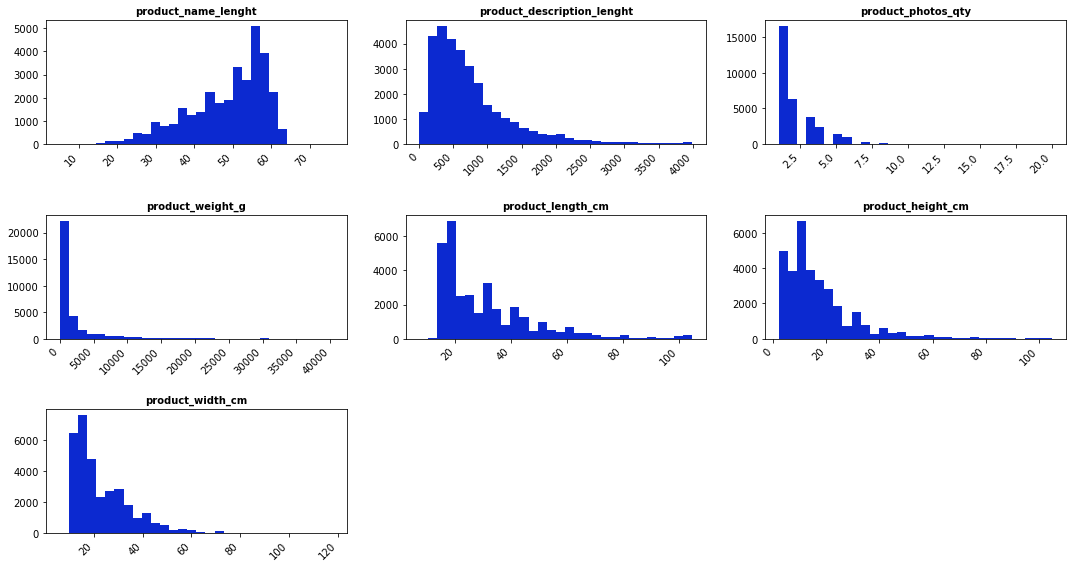

In [149]:
col_quanti = products.select_dtypes(exclude='object').columns.tolist()
fig = plt.figure(figsize=(15, 8))
univ_plots_hist(products, col_quanti, 3, 3, 30)

['product_id', 'product_category_name']


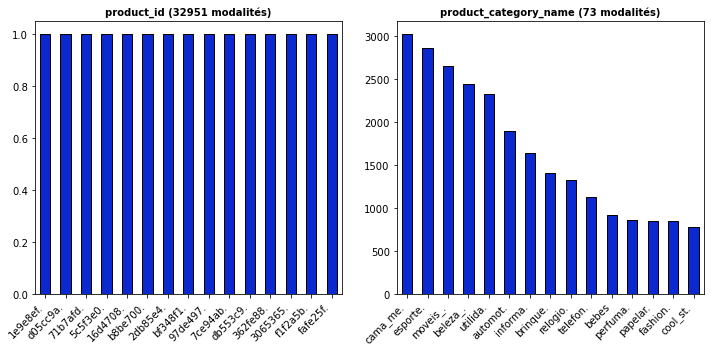

In [150]:
col_quali = products.select_dtypes(include='object').columns.tolist()
print(col_quali)

fig = plt.figure(figsize=(10, 5))
univariate_plots_quali(products, col_quali, 1, 2)

In [151]:
# Doublons totaux
print(f"Lignes en doublons: {products.duplicated().sum()}")

Lignes en doublons: 0


Observations:

- quelques valeurs manquantes
- product_id est la clef qui fait le lien avec le dataset products => pas de doublons

### olist_sellers_dataset.csv

Informations sur les vendeurs.

In [152]:
# Visualisation des 5 premières lignes du dataset
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [153]:
# Shape du dataset
shape_total_nan(sellers)

Nombre de lignes: 3095
Nombre de colonnes: 4
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [154]:
# Description des variables
describe_variables(sellers)

C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFram

,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,seller_id,object,3442f8959a84dea7ee197c632cb2df15,3095,3095,100.0,3095,100.0,0,0.0,,,,,,,,,,
1,seller_zip_code_prefix,int64,13023,3095,2246,72.57,3095,100.0,0,0.0,,,,,,,,,,
2,seller_city,object,campinas,3095,611,19.74,3095,100.0,0,0.0,,,,,,,,,,
3,seller_state,object,SP,3095,23,0.74,3095,100.0,0,0.0,,,,,,,,,,


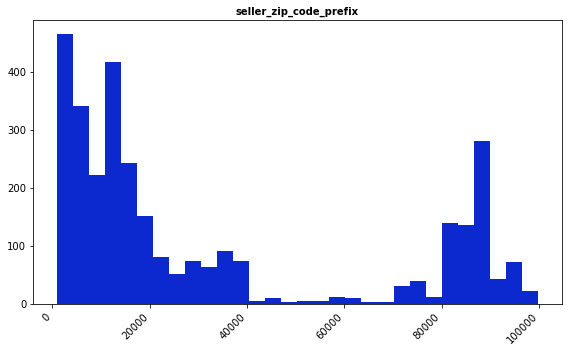

In [156]:
col_quanti = sellers.select_dtypes(exclude='object').columns.tolist()
fig = plt.figure(figsize=(8, 5))
univ_plots_hist(sellers, col_quanti, 1, 1, 30)

['seller_id', 'seller_city', 'seller_state']


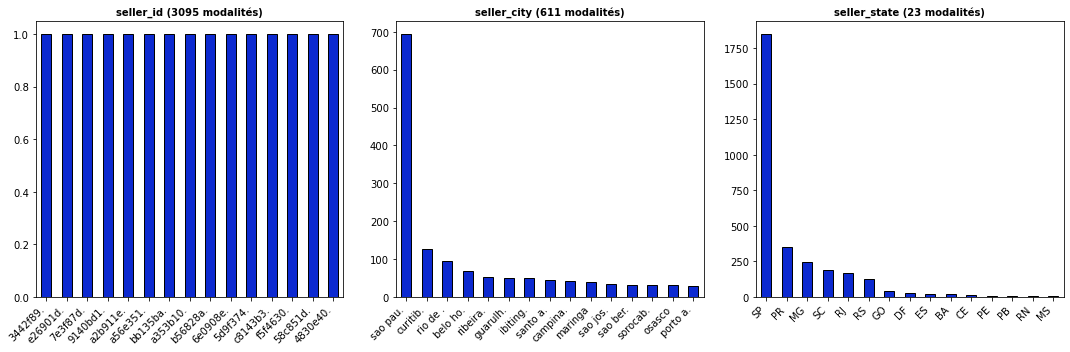

In [157]:
col_quali = sellers.select_dtypes(include='object').columns.tolist()
print(col_quali)

fig = plt.figure(figsize=(15, 5))
univariate_plots_quali(sellers, col_quali, 1, 3)

In [158]:
# Doublons totaux
print(f"Lignes en doublons: {sellers.duplicated().sum()}")

Lignes en doublons: 0


Observations:

- aucune valeur manquante
- seller_id est la clef qui fait le lien avec le dataset order_items et zip_code_prefix avec le dataset geolocation
- pas de lignes dupliquées pour seller_id

### product_category_name_translation.csv

Traduction des categories des produits en anglais.

In [159]:
# Visualisation des 5 premières lignes du dataset
category.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [160]:
# Shape du dataset
shape_total_nan(category)

Nombre de lignes: 71
Nombre de colonnes: 2
Nombre total de NaN du dataset: 0
% total de NaN du dataset: 0.0%


In [161]:
# Description des variables
describe_variables(category)

C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,
C:\Users\milie\AppData\Local\Temp\ipykernel_29692\1955748792.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[col, var_type, example,


,Variable name,Variable type,Example,Raws,Distinct,% distinct,Not NaN,% Not NaN,NaN,% NaN,Mean,Median,Skew,Kurtosis,Variance,Std,Min,25%,75%,Max
0,product_category_name,object,beleza_saude,71,71,100.0,71,100.0,0,0.0,,,,,,,,,,
1,product_category_name_english,object,health_beauty,71,71,100.0,71,100.0,0,0.0,,,,,,,,,,


In [162]:
# Doublons totaux
print(f"Lignes en doublons: {category.duplicated().sum()}")

Lignes en doublons: 0


Observations:

- aucune valeur manquante

## Consolidation des données <a class="anchor" id="conso"></a>

<div class="alert alert-block alert-info">
    <p> OK jointures left?</p>
</div>

In [166]:
# Merge orders avec customers
df_conso = pd.merge(left=orders, right=customers, how='left', on='customer_id')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 99441
Nombre de colonnes: 12
Nombre total de NaN du dataset: 4908
% total de NaN du dataset: 0.41%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [167]:
# Merge orders avec reviews
df_conso = pd.merge(left=df_conso, right=reviews, how='left', on='order_id')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 99441
Nombre de colonnes: 18
Nombre total de NaN du dataset: 154473
% total de NaN du dataset: 8.63%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e estava descrito no site e chegou bem antes da data prevista.,2017-12-03 00:00:00,2017-12-05 19:21:58
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51


In [168]:
# Merge avec payments
df_conso = pd.merge(left=df_conso, right=payments, how='left', on='order_id')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 103887
Nombre de colonnes: 22
Nombre total de NaN du dataset: 161536
% total de NaN du dataset: 7.07%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,1.0,credit_card,3.0,179.12


In [169]:
# Merge avec order_items
df_conso = pd.merge(left=df_conso, right=items, how='left', on='order_id')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 118434
Nombre de colonnes: 28
Nombre total de NaN du dataset: 187468
% total de NaN du dataset: 5.65%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,credit_card,1.0,18.12,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,3.0,voucher,1.0,2.00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,2.0,voucher,1.0,18.59,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,boleto,1.0,141.46,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,1.0,credit_card,3.0,179.12,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22


In [170]:
# Merge avec products
df_conso = pd.merge(left=df_conso, right=products, how='left', on='product_id')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 118434
Nombre de colonnes: 36
Nombre total de NaN du dataset: 200980
% total de NaN du dataset: 4.71%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,credit_card,1.0,18.12,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,3.0,voucher,1.0,2.00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,2.0,voucher,1.0,18.59,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,boleto,1.0,141.46,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,1.0,credit_card,3.0,179.12,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0


In [171]:
# Merge avec sellers
df_conso = pd.merge(left=df_conso, right=sellers, how='left', on='seller_id')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 118434
Nombre de colonnes: 39
Nombre total de NaN du dataset: 203470
% total de NaN du dataset: 4.41%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,credit_card,1.0,18.12,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,3.0,voucher,1.0,2.00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,2.0,voucher,1.0,18.59,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,boleto,1.0,141.46,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58,1.0,credit_card,3.0,179.12,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP


In [174]:
# Merge avec geo
df_conso = pd.merge(left=df_conso, right=geo, how='left',
                    left_on='seller_zip_code_prefix',
                    right_on='geolocation_zip_code_prefix')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 118434
Nombre de colonnes: 49
Nombre total de NaN du dataset: 214380
% total de NaN du dataset: 3.69%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix_x,geolocation_lat_x,geolocation_lng_x,geolocation_city_x,geolocation_state_x,geolocation_zip_code_prefix_y,geolocation_lat_y,geolocation_lng_y,geolocation_city_y,geolocation_state_y
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,1.0,credit_card,1.0,18.12,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,9350.0,-23.680862,-46.444311,maua,SP,9350.0,-23.680862,-46.444311,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,3.0,voucher,1.0,2.00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,9350.0,-23.680862,-46.444311,maua,SP,9350.0,-23.680862,-46.444311,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11 00:00:00,2017-10-12 03:43:48,2.0,voucher,1.0,18.59,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP,9350.0,-23.680862,-46.444311,maua,SP,9350.0,-23.680862,-46.444311,maua,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50,1.0,boleto,1.0,141.46,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP,31570.0,-19.807885,-43.980818,belo horizonte,MG,31570.0,-19.807885,-43.980818,belo horizonte,MG
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc

In [164]:
# Merge avec order_items
df_conso = pd.merge(left=df_conso, right=items, how='left', on='order_id')
shape_total_nan(df_conso)
df_conso.head()

Nombre de lignes: 113425
Nombre de colonnes: 18
Nombre total de NaN du dataset: 10008
% total de NaN du dataset: 0.49%


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [ ]:
# Merge avec products
df_conso = pd.merge(left=df_conso, right=products, how='left', on='product_id')
shape_total_nan(df_conso)
df_conso.head()

In [ ]:
# Merge avec sellers
df_conso = pd.merge(left=df_conso, right=sellers, how='left', on='seller_id')
shape_total_nan(df_conso)
df_conso.head()

In [ ]:
# Merge avec payments
df_conso = pd.merge(left=df_conso, right=payments, how='left', on='order_id')
shape_total_nan(df_conso)
df_conso.head()

In [ ]:
# Merge avec reviews
df_conso = pd.merge(left=df_conso, right=reviews, how='left', on='order_id')
shape_total_nan(df_conso)
df_conso.head()

In [ ]:
geo
category



orders / customers
reviews
payments
items
products
sellers